# Train LDA and Word2Vec Models

This notebook includes code to train and evaluate both LDA and Word2Vec models

In [98]:
import pickle
import matplotlib.pyplot as plt
from gensim import models, corpora
import pandas as pd
import numpy as np

import pyLDAvis
import pyLDAvis.gensim

#### 10,000 recipes from 'compiled_recipes' dataframe were set aside for the test set 

In [5]:
with open('df_train.pickle', 'rb') as f:
    df_train = pickle.load(f)

with open('df_test.pickle', 'rb') as f:
    df_test = pickle.load(f)

### LDA with 4 topics

In [34]:
num_topics = 4

dictionary = corpora.Dictionary(df_train['instructions'])
corpus = [dictionary.doc2bow(text) for text in df_train['instructions']]

lda_model = models.LdaModel(corpus=corpus, 
                            num_topics=num_topics, 
                            alpha = [.01]*num_topics,
                            iterations = 100,
                            passes = 10,
                            id2word=dictionary)

In [35]:
'''
lda_model.save('lda_model_10p4t_full_training.gensim')
dictionary.save('lda_10p4t_full_training_dictionary')
'''

In [94]:
## load LDA model
lda_model = models.LdaModel.load('lda_model_10p4t_full_training.gensim')
dictionary = corpora.Dictionary.load('lda_10p4t_full_training_dictionary')

### Visualize topics using pyLDAvis

In [102]:
pyLDAvis.enable_notebook()

#dictionary = corpora.Dictionary(df_train['instructions'])
#corpus = [dictionary.doc2bow(text) for text in df_train['instructions']]
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics = False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.160150 -0.062474       1        1  29.290798
1     -0.186731 -0.099251       2        1  16.763657
2      0.094173  0.014857       3        1  26.158920
3     -0.067593  0.146867       4        1  27.786627, topic_info=     Category           Freq       Term          Total  loglift  logprob
term                                                                    
32    Default  118344.000000       bake  118344.000000  30.0000  30.0000
77    Default  184103.000000       heat  184103.000000  29.0000  29.0000
4     Default  127306.000000       cook  127306.000000  28.0000  28.0000
92    Default   96040.000000     pepper   96040.000000  27.0000  27.0000
7     Default   44610.000000      dough   44610.000000  26.0000  26.0000
21    Default   83293.000000      water   83293.000000  25.0000  25.0000
47    Default   86739.000000       oven   86739.000000  24.0000  24.0000
203   Default   32310.000000       beat   32310.000000  23.0000  23.0000
311   Default   32197.000000       cake   32197.000000  22.0000  22.0000
500   Default   30508.000000      grill   30508.000000  21.0000  21.0000
101   Default   57541.000000    skillet   57541.000000  20.0000  20.0000
105   Default  138039.000000       stir  138039.000000  19.0000  19.0000
173   Default  102328.000000        oil  102328.000000  18.0000  18.0000
60    Default  191303.000000        add  191303.000000  17.0000  17.0000
185   Default   45113.000000     simmer   45113.000000  16.0000  16.0000
55    Default   69744.000000      sugar   69744.000000  15.0000  15.0000
29    Default   34076.000000        pot   34076.000000  14.0000  14.0000
134   Default   56642.000000       boil   56642.000000  13.0000  13.0000
180   Default   55225.000000     season   55225.000000  12.0000  12.0000
49    Default   51307.000000    preheat   51307.000000  11.0000  11.0000
30    Default   26533.000000      roast   26533.000000  10.0000  10.0000
120   Default   47860.000000        egg   47860.000000   9.0000   9.0000
75    Default   48566.000000      flour   48566.000000   8.0000   8.0000
1     Default   71956.000000     butter   71956.000000   7.0000   7.0000
14    Default   46345.000000      onion   46345.000000   6.0000   6.0000
13    Default  273617.000000      minut  273617.000000   5.0000   5.0000
235   Default   21468.000000     chocol   21468.000000   4.0000   4.0000
97    Default  136166.000000       salt  136166.000000   3.0000   3.0000
48    Default   93199.000000        pan   93199.000000   2.0000   2.0000
632   Default   19059.000000        ice   19059.000000   1.0000   1.0000
...       ...            ...        ...            ...      ...      ...
32     Topic4   85937.164062       bake  118344.570312   0.9606  -3.5795
75     Topic4   37716.511719      flour   48566.703125   1.0278  -4.4030
90     Topic4   11844.774414  parchment   13689.670898   1.1359  -5.5612
55     Topic4   47459.800781      sugar   69744.007812   0.8957  -4.1732
1      Topic4   45323.187500     butter   71956.851562   0.8184  -4.2193
338    Topic4    9752.924805     pastri   11886.394531   1.0828  -5.7555
86     Topic4   16185.662109       milk   21812.792969   0.9822  -5.2490
125    Topic4   24909.783203       rack   37181.906250   0.8801  -4.8178
119    Topic4   38627.652344       cool   64811.367188   0.7631  -4.3791
184    Topic4   33529.929688      sheet   54434.507812   0.7961  -4.5207
48     Topic4   51526.527344        pan   93199.250000   0.6880  -4.0910
27     Topic4   53872.078125     mixtur  101254.164062   0.6496  -4.0465
198    Topic4   36049.980469      whisk   61438.296875   0.7475  -4.4482
47     Topic4   46321.000000       oven   86739.039062   0.6533  -4.1975
34     Topic4   62007.542969       bowl  155567.578125   0.3608  -3.9058
49     Topic4   26921.884766    preheat   51307.406250   0.6357  -4.7402
13     Topic4   75635.929688      minut  273617.968750  

Topic 1: stovetop meals<br>
Topic 2: cold items and drinks<br>
Topic 3: oven and grill meals<br>
Topic 4: baked sweets<br>

### Plot max weight distribution

In [8]:
recipes_max_weight = []
for i in df_train['instructions']:
    bow = dictionary.doc2bow(i)
    weights = lda_model[bow]
    max_weight = sorted(weights, key=lambda x: x[1])[-1:][0][1]
    recipes_max_weight.append(max_weight)

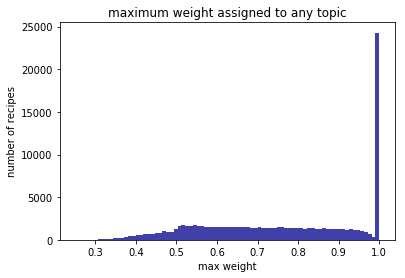

In [9]:
n, bins, patches = plt.hist(recipes_max_weight, 80, facecolor='darkblue', alpha=0.75)
plt.xlabel("max weight")
plt.ylabel("number of recipes")
plt.title("maximum weight assigned to any topic")
plt.show()

## Train word embeddings based on all data

In [13]:
full_model = models.Word2Vec(size=200, #number of features (dimensions)
                               window=20, #window size encompasses entire list of ingredients
                               min_count=20, #minimum instances of word in corpus to be included
                               workers=6,
                               sample = 5e-5, #randomly downsample common words
                               sg = 1) #skipgram method
full_model.build_vocab(df_train['ingredients'])
full_model.train(df_train['ingredients'],
            total_examples=full_model.corpus_count, 
            epochs=100)

(16116900, 99002100)

### Evaluate model using the top suggestion for each staple

In [18]:
##list of staples
df_staples = pd.read_csv('staples_tagged_singular.csv')
all_staples = list(df_staples['AbbrvName'])

In [72]:
recipes = df_test['ingredients']

model = full_model
vocab = model.wv.vocab
staple_cats = list(df_staples['Group'])

saved_results = {}
val_list = []
for recipe in recipes:
    
    ## reduce ingredient lists to staples for comparison
    staples_in = [i for i in recipe if i in all_staples]
    for staple in staples_in:
        if staple not in vocab:
            continue
        else:
            
            ## output results for staple if previously assessed
            if staple in saved_results:
                val_list.append(saved_results[staple])
            else:
                
                ## get most similar foods to given staple
                similar_foods = model.wv.most_similar(staple, topn = 5)
                
                ## exclude non-staples suggestions
                similar_staples = [i[0] for i in similar_foods if i[0] in all_staples]
                if similar_staples:
                    
                    ## determine if staple and suggestion categories match
                    in_group = staple_cats[all_staples.index(staple)]
                    out_group = staple_cats[all_staples.index(similar_staples[0])]
                    output = (in_group == out_group, in_group)
                    
                    ## output results and save results for staple to dictionary
                    val_list.append(output)
                    saved_results[staple] = output
  

In [75]:
for group in df_staples['Group'].unique():
    results = [x[0] for x in val_list if x[1] == group]
    print(group, np.mean(results))

p 0.7103568320278503
v 0.7881344307270233
s 0.43840696549500163
g 0.8154402895054282
f 0.8303333855063391
o 0.0
l 0.8266078184110971


## Train word embeddings per topic


In [6]:
recipes_topics = []
recipes_max_weight = []
for i in df_recipes['instructions']:
    bow = dictionary.doc2bow(i)
    weights = lda_model[bow]
    t_w = sorted(weights, key=lambda x: x[1])[-1:][0]
    recipes_topics.append(t_w[0])
    recipes_max_weight.append(t_w[1])

df_train['topic'] = recipes_topics
df_train['weight'] = recipes_max_weight

In [8]:
## restrict to recipes with majority of weight assigned to 1 topic

df_train2 = df_train.loc[df['weight'] > .5]

In [22]:
##train word2vec with 1 topic per recipe
def model_n_save(df_topic):
    model = models.Word2Vec(
        size=200,
        window=20,
        min_count=20,
        workers=6,
        sample = 5e-5,
        sg = 1)
    model.build_vocab(df_topic['ingredients'])
    model.train(df_topic['ingredients'], 
                total_examples=model.corpus_count, 
                epochs=100)
    return model

by_topic = df_train2.groupby('topic')
w2v_models_single = by_topic.apply(model_n_save)


In [77]:
model_list = []
for i in range(4):
    file = 'w2v_topic'+ str(i)+ '_fulltrain.model'
    model = models.Word2Vec.load(file)
    model_list.append(model)

### Evaluate each model using the top suggestion for each staple

In [88]:
recipes = df_test['ingredients']

staple_cats = list(df_staples['Group'])

saved_results = [{}, {}, {}, {}]
val_list = []
for recipe in recipes:
    
    ## apply LDA for topic assignment
    bow = dictionary.doc2bow(recipe)
    topic = sorted(lda_model[bow], key=lambda x: x[1])[-1:][0][0]
    
    ## select word2vec model for designated topic
    model = model_list[topic]
    
    ## reduce ingredient lists to staples for comparison
    staples_in = [i for i in recipe if i in all_staples]
    
    for staple in staples_in:
        if staple not in model.wv.vocab:
            continue
        else:
            ## output results for staple if previously assessed
            if staple in saved_results[topic]:
                val_list.append(saved_results[topic][staple])
            else:
                ## get most similar foods to given staple
                similar_foods = model.wv.most_similar(staple, topn = 5)
                
                ## exclude non-staples suggestions
                similar_staples = [i[0] for i in similar_foods if i[0] in all_staples]
                if similar_staples:
                    
                    ## determine if staple and suggestion categories match
                    in_group = staple_cats[all_staples.index(staple)]
                    out_group = staple_cats[all_staples.index(similar_staples[0])]
                    output = (in_group == out_group, in_group, topic)
                    
                    ## output results and save results for staple to dictionary
                    val_list.append(output)
                    saved_results[topic][staple] = output

In [87]:
## print accuracy for each category of food
# protein, veg, spices, grains, fruit, oils, liquids
for group in df_staples['Group'].unique():
    results = [x[0] for x in val_list if x[1] == group]
    print(group, np.mean(results))

p 0.761308886509636
v 0.5037479178234314
s 0.4329750709061054
g 0.627497062279671
f 0.6403605883283252
o 0.0
l 0.8383280757097792


In [93]:
## print accuracy by topic
for topic in range(4):
    subset = [x for x in val_list if x[2] == topic]
    print('topic', topic)
    for group in df_staples['Group'].unique():
        results = [x[0] for x in subset if x[1] == group]
        print(group, np.mean(results))
        if group == 'l':
            print('\n')

topic 0
p 0.9032163742690058
v 0.33290964940154644
s 0.43271767810026385
g 0.9145907473309609
f 0.5295794725588026
o 0.0
l 0.8568702290076335


topic 1
p 0.4703703703703704
v 0.2777777777777778
s 0.22099447513812154
g 0.0
f 0.7703631010794897
o 0.0
l 0.0


topic 2
p 0.8844841165660279
v 0.8629154898978927
s 0.3709213051823417
g 0.0
f 0.3693212185996793
o 0.0
l 0.9166666666666666


topic 3
p 0.42058165548098436
v 0.33126934984520123
s 0.5380263984915148
g 0.09049773755656108
f 0.8966535433070866
o 0.0
l 0.0


